In [2]:
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 19.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.1/808.1 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 19.7 MB/s eta 0:00:0031m20.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 16.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [41]:

import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [42]:
CSV_PATH = 'merged_dataset.csv'   # update if needed
FEATURES = ['StudyHours', 'Attendance', 'Motivation', 'ExamScore']  # choose 2-5 features
TARGET = 'FinalGrade'
HIDDEN_NEURONS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.01
EPOCHS = 200           # you can increase later
RANDOM_SEED = 42

In [43]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [44]:
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Dataset not found at {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
print("Dataset shape:", df.shape)
print("Available columns:", df.columns.tolist())

# Make sure features and target exist
for c in FEATURES + [TARGET]:
    if c not in df.columns:
        raise ValueError(f"Column '{c}' not found in dataset. Choose different FEATURES/TARGET.")


Dataset shape: (14003, 16)
Available columns: ['StudyHours', 'Attendance', 'Resources', 'Extracurricular', 'Motivation', 'Internet', 'Gender', 'Age', 'LearningStyle', 'OnlineCourses', 'Discussions', 'AssignmentCompletion', 'ExamScore', 'EduTech', 'StressLevel', 'FinalGrade']


In [45]:
data = df[FEATURES + [TARGET]].copy()
# Fill missing values with median (simple strategy)
data.fillna(data.median(), inplace=True)

# Inputs and target arrays
X = data[FEATURES].astype(float).values
y = data[[TARGET]].astype(float).values  # shape (n,1)

# Scale inputs and target (helps training)
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=RANDOM_SEED
)

# Convert to torch tensors
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)


In [46]:
def manual_single_sample_demo():
    print("\n--- Manual single-sample forward + backward demo ---")
    # pick first raw (unscaled) sample for clarity
    X0 = X[0].reshape(-1, 1)  # shape (features, 1)
    y0 = y[0, 0]

    # small random initial weights (hidden layer 3 neurons for the demo)
    hidden_demo = 3
    W1 = np.random.randn(hidden_demo, X0.shape[0]) * 0.1   # (hidden, input)
    b1 = np.zeros((hidden_demo, 1))
    W2 = np.random.randn(1, hidden_demo) * 0.1             # (output, hidden)
    b2 = np.zeros((1, 1))

    # Forward
    Z1 = W1.dot(X0) + b1                 # (hidden,1)
    A1 = np.maximum(0, Z1)               # ReLU
    Z2 = W2.dot(A1) + b2                 # (1,1)
    y_hat = Z2[0, 0]
    print(f"Manual forward -> predicted (raw scale): {y_hat:.4f}, actual: {y0:.4f}")

    # Loss (MSE for single sample): 0.5*(y-yhat)^2  (some use 1/2 for simpler derivative)
    loss = 0.5 * (y0 - y_hat) ** 2
    print(f"Manual loss (0.5 * (y - yhat)^2): {loss:.6f}")

    # Backward (manual gradients)
    # dL/dyhat = -(y - yhat)
    dL_dyhat = -(y0 - y_hat)
    # dL/dW2 = dL/dyhat * d(yhat)/dW2 = dL_dyhat * A1^T
    dW2 = dL_dyhat * A1.T                # shape (1, hidden)
    db2 = dL_dyhat
    # Backprop into hidden: dL/dA1 = dL/dyhat * W2^T
    dA1 = dL_dyhat * W2.T                # (hidden,1)
    # dA1/dZ1 = ReLU'(Z1) -> 1 if Z1>0 else 0
    dZ1 = dA1 * (Z1 > 0).astype(float)
    # dL/dW1 = dZ1 * X0^T
    dW1 = dZ1.dot(X0.T)

    print("Shapes: W1", W1.shape, "dW1", dW1.shape, "W2", W2.shape, "dW2", dW2.shape)
    print("--- end manual demo ---\n")

# Run manual demo (optional)
manual_single_sample_demo()


--- Manual single-sample forward + backward demo ---
Manual forward -> predicted (raw scale): -0.1904, actual: 3.0000
Manual loss (0.5 * (y - yhat)^2): 5.089429
Shapes: W1 (3, 4) dW1 (3, 4) W2 (1, 3) dW2 (1, 3)
--- end manual demo ---



In [47]:
class SimpleANN(nn.Module):
    def __init__(self, input_dim, hidden_neurons, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neurons)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

model = SimpleANN(input_dim=X_train.shape[1], hidden_neurons=HIDDEN_NEURONS, output_dim=1)
print("Model:", model)

Model: SimpleANN(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


In [48]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [49]:
loss_history = []
for epoch in range(1, EPOCHS+1):
    model.train()
    batch_losses = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    epoch_loss = float(np.mean(batch_losses))
    loss_history.append(epoch_loss)
    if epoch % max(1, EPOCHS//10) == 0 or epoch == 1:
        print(f"Epoch {epoch}/{EPOCHS} - Train MSE (scaled target): {epoch_loss:.6f}")

Epoch 1/200 - Train MSE (scaled target): 0.093148
Epoch 20/200 - Train MSE (scaled target): 0.044044
Epoch 40/200 - Train MSE (scaled target): 0.018952
Epoch 60/200 - Train MSE (scaled target): 0.011780
Epoch 80/200 - Train MSE (scaled target): 0.010735
Epoch 100/200 - Train MSE (scaled target): 0.009356
Epoch 120/200 - Train MSE (scaled target): 0.009251
Epoch 140/200 - Train MSE (scaled target): 0.005814
Epoch 160/200 - Train MSE (scaled target): 0.005546
Epoch 180/200 - Train MSE (scaled target): 0.005235
Epoch 200/200 - Train MSE (scaled target): 0.004678


In [50]:
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy()

preds = scaler_y.inverse_transform(preds_scaled)
y_test_orig = scaler_y.inverse_transform(y_test)

In [51]:
print("\nSample predictions (first 10 test samples):")
n_show = min(10, len(preds))
for i in range(n_show):
    print(f"Predicted: {preds[i,0]:.3f} \t Actual: {y_test_orig[i,0]:.3f}")


Sample predictions (first 10 test samples):
Predicted: 2.036 	 Actual: 2.000
Predicted: 2.062 	 Actual: 2.000
Predicted: 2.021 	 Actual: 2.000
Predicted: 0.120 	 Actual: -0.000
Predicted: 0.060 	 Actual: -0.000
Predicted: 0.106 	 Actual: -0.000
Predicted: 2.046 	 Actual: 2.000
Predicted: 3.149 	 Actual: 3.000
Predicted: 0.123 	 Actual: -0.000
Predicted: 1.028 	 Actual: 1.000


In [52]:
r2  = r2_score(y_test_orig, preds)
mae = mean_absolute_error(y_test_orig, preds)
mse = mean_squared_error(y_test_orig, preds)
rmse = np.sqrt(mse)

print("\n📌 MODEL ACCURACY METRICS")
print(f"R² Score:  {r2:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"MSE:       {mse:.4f}")
print(f"RMSE:      {rmse:.4f}")


📌 MODEL ACCURACY METRICS
R² Score:  0.9945
MAE:       0.0680
MSE:       0.0071
RMSE:      0.0841


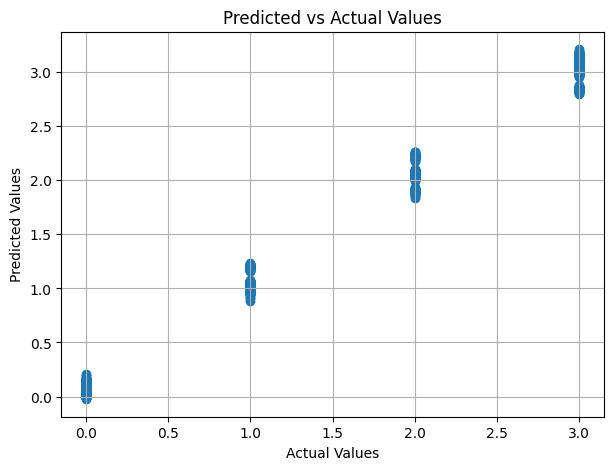

In [53]:
plt.figure(figsize=(7,5))
plt.scatter(y_test_orig, preds)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.grid(True)
plt.show()

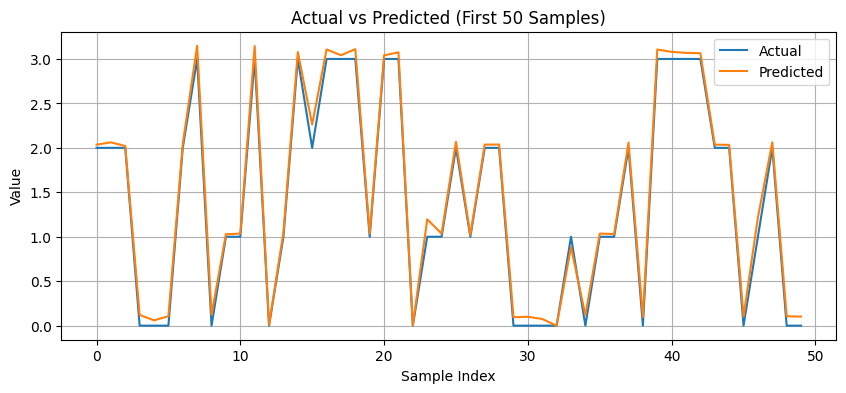

In [54]:
plt.figure(figsize=(10,4))
plt.plot(y_test_orig[:50], label="Actual")
plt.plot(preds[:50], label="Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Actual vs Predicted (First 50 Samples)")
plt.legend()
plt.grid(True)
plt.show()

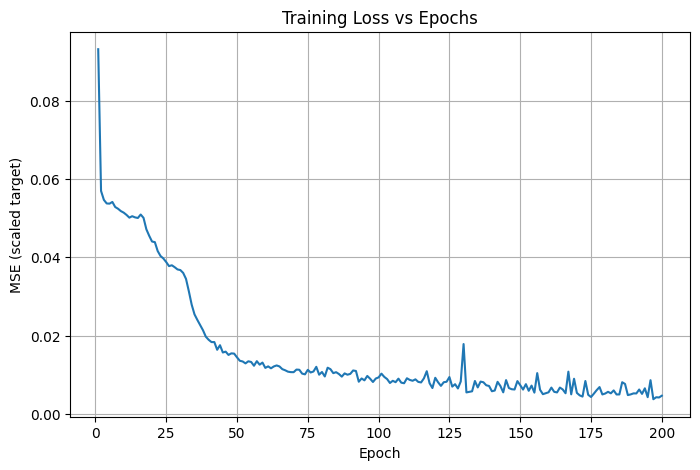

In [55]:
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled target)")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.show()

In [56]:
os.makedirs('outputs_ANN', exist_ok=True)
torch.save(model.state_dict(), 'outputs_ANN/ann_model.pth')

report_txt = 'outputs_ANN/ann_report.txt'
with open(report_txt, 'w') as f:
    f.write("ANN Student Scores Training Report\n")
    f.write(f"Features: {FEATURES}\nTarget: {TARGET}\n")
    f.write(f"Model: Input {X_train.shape[1]} -> Hidden {HIDDEN_NEURONS} (ReLU) -> Output 1\n")
    f.write(f"Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}, LR: {LEARNING_RATE}\n")
    f.write(f"Final Train MSE (scaled): {loss_history[-1]:.6f}\n\n")
    f.write("Sample predictions vs actuals (first 10 test samples):\n")
    for i in range(n_show):
        f.write(f"Predicted: {preds[i,0]:.3f} \t Actual: {y_test_orig[i,0]:.3f}\n")

print(f"\nModel saved to: outputs_ANN/ann_model.pth")
print(f"Report saved to: {report_txt}")


Model saved to: outputs_ANN/ann_model.pth
Report saved to: outputs_ANN/ann_report.txt


In [57]:
import torch
print(torch.__version__)

2.9.1
